In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    accuracy_score
)

In [2]:
# Load dataset + metadata
(ds_all, ds_info) = tfds.load(
    "plant_village",
    split="train",
    as_supervised=True,
    with_info=True
)

total = ds_info.splits["train"].num_examples
print("Total images:", total)

# Shuffle with fixed seed
ds_all = ds_all.shuffle(10000, seed=4, reshuffle_each_iteration=False)

# Subset sizes
train_count = 10000
val_count   = 2000
test_count  = 2000

train_ds = ds_all.take(train_count)
rest_ds  = ds_all.skip(train_count)
val_ds   = rest_ds.take(val_count)
test_ds  = rest_ds.skip(val_count).take(test_count)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/plant_village/incomplete.4PKMJL_1.0.2/plant_village-train.tfrecord*...:   …

Dataset plant_village downloaded and prepared to /root/tensorflow_datasets/plant_village/1.0.2. Subsequent calls will reuse this data.
Total images: 54303


In [3]:
# Data augmentation layers
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),
    ],
    name="data_augmentation",
)

AUTOTUNE = tf.data.AUTOTUNE

def prepare_dataset(ds, img_size, batch_size, training):
    def _resize_normalize(image, label):
        image = tf.image.resize(image, (img_size, img_size))
        image = tf.cast(image, tf.float32)
        return image, label

    ds = ds.map(_resize_normalize, num_parallel_calls=AUTOTUNE)

    if training:
        ds = ds.shuffle(1000)
        ds = ds.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=AUTOTUNE
        )

    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds


In [4]:
IMG_SIZE = 299
BATCH_SIZE = 32
NUM_CLASSES = ds_info.features["label"].num_classes

train = prepare_dataset(train_ds, IMG_SIZE, BATCH_SIZE, training=True)
val   = prepare_dataset(val_ds, IMG_SIZE, BATCH_SIZE, training=False)
test  = prepare_dataset(test_ds, IMG_SIZE, BATCH_SIZE, training=False)


In [5]:
base = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base.trainable = False  # Freeze base layers first

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.inception_v3.preprocess_input(inputs)
x = base(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 38)             │        77,862 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,880,646 (83.47 MB)

 Trainable params: 77,862 (304.15 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [6]:
history = model.fit(
    train,
    validation_data=val,
    epochs=10
)


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 104s 268ms/step - accuracy: 0.1781 - loss: 3.1990 - val_accuracy: 0.4720 - val_loss: 2.1895
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 69s 215ms/step - accuracy: 0.4865 - loss: 2.0730 - val_accuracy: 0.6560 - val_loss: 1.6005
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 69s 215ms/step - accuracy: 0.6330 - loss: 1.5632 - val_accuracy: 0.7280 - val_loss: 1.2789
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 69s 214ms/step - accuracy: 0.6971 - loss: 1.2975 - val_accuracy: 0.7700 - val_loss: 1.0725
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 69s 214ms/step - accuracy: 0.7540 - loss: 1.0769 - val_accuracy: 0.7845 - val_loss: 0.9449
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 68s 213ms/step - accuracy: 0.7778 - loss: 0.9557 - val_accuracy: 0.8080 - val_loss: 0.8385
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 68s 211ms/step - accuracy: 0.7971 - loss: 0.8642 - val_accuracy: 0.8140 - val_loss: 0.7687
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 68s 210ms/step - accuracy: 0.8077 - loss: 

In [7]:
base.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_ft = model.fit(
    train,
    validation_data=val,
    epochs=5
)


Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 275s 639ms/step - accuracy: 0.5910 - loss: 1.5714 - val_accuracy: 0.8945 - val_loss: 0.4084
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 159s 501ms/step - accuracy: 0.8910 - loss: 0.4107 - val_accuracy: 0.9360 - val_loss: 0.2425
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 161s 510ms/step - accuracy: 0.9326 - loss: 0.2519 - val_accuracy: 0.9520 - val_loss: 0.1778
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 161s 509ms/step - accuracy: 0.9476 - loss: 0.1886 - val_accuracy: 0.9640 - val_loss: 0.1363
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 161s 510ms/step - accuracy: 0.9661 - loss: 0.1265 - val_accuracy: 0.9650 - val_loss: 0.1197


In [8]:
y_true = []
y_pred = []

for batch_images, batch_labels in test:
    preds = model.predict(batch_images)
    y_true.extend(batch_labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [9]:
acc = accuracy_score(y_true, y_pred)
f1_macro = f1_score(y_true, y_pred, average="macro")
f1_weighted = f1_score(y_true, y_pred, average="weighted")

print("Test Accuracy:", acc)
print("Macro F1 Score:", f1_macro)
print("Weighted F1 Score:", f1_weighted)


Test Accuracy: 0.9735
Macro F1 Score: 0.9625056971968028
Weighted F1 Score: 0.9729397202757472


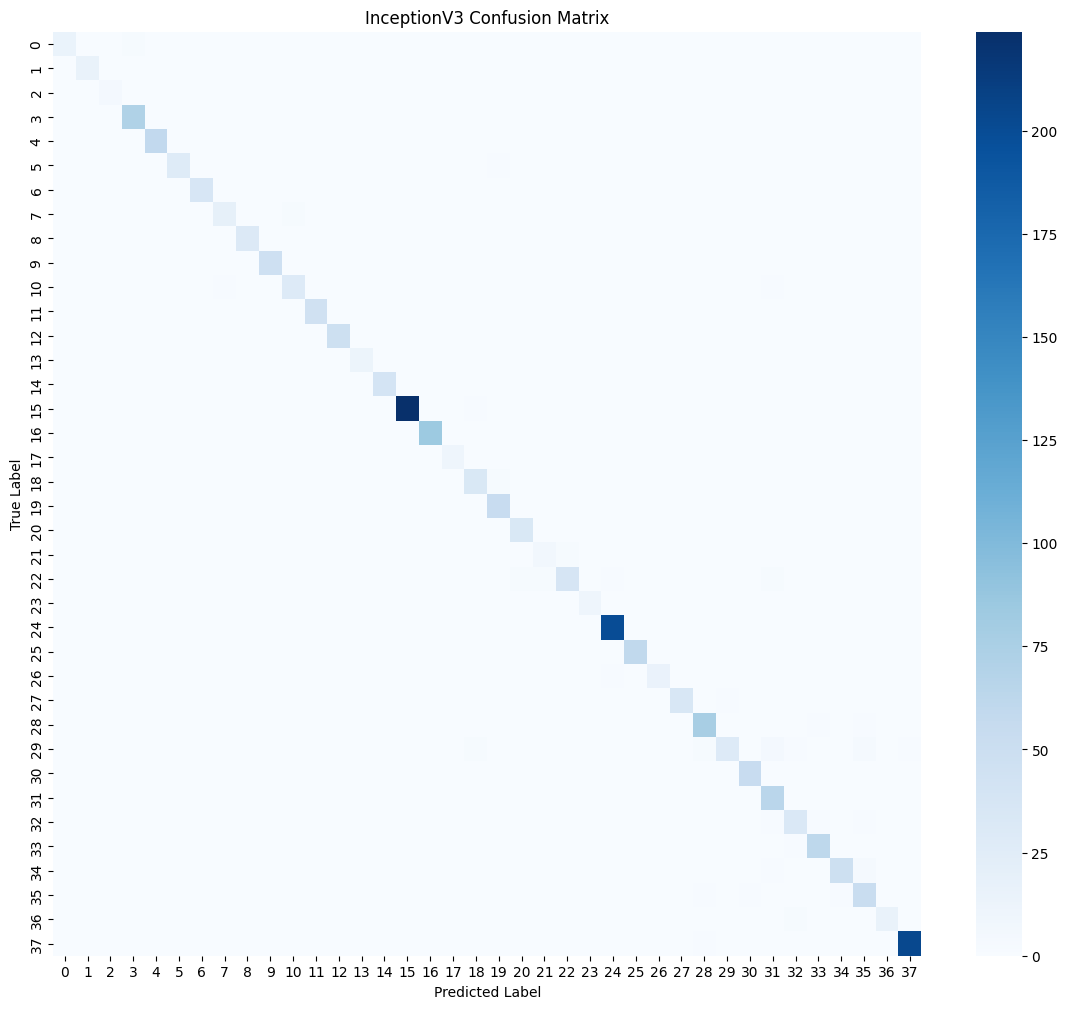

In [10]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("InceptionV3 Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [11]:
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.88      0.93        16
           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00         5
           3       0.97      1.00      0.99        71
           4       1.00      1.00      1.00        59
           5       1.00      0.97      0.98        29
           6       1.00      1.00      1.00        36
           7       0.95      0.91      0.93        22
           8       1.00      1.00      1.00        31
           9       1.00      1.00      1.00        47
          10       0.94      0.94      0.94        31
          11       1.00      1.00      1.00        45
          12       1.00      1.00      1.00        48
          13       1.00      1.00      1.00        13
          14       1.00      1.00      1.00        40
          15       1.00      1.00      1.00       225
          16       1.00      1.00      1.00        84
          17       1.00    